# Main PyEPO
This notebook uses our classes in close connection with the PyEPO library and follows their tutorial in creating a shortest path optnet.

In [1]:
# Add the parent directory to the path
import sys, os
sys.path.insert(0, os.path.abspath("../.."))

## Optimizers
We start with defining an optimization problem with an optimizer.

In [2]:
# Import numpy and ShortestPathGrb class
import numpy as np
from src.models.ShortestPathGrb import shortestPathGrb

In [3]:
# Define grid size
m, n = 5, 5

# Create a grid instance
opt_model = shortestPathGrb()

Restricted license - for non-production use only - expires 2026-11-23


In [4]:
# Define random cost
cost = np.random.rand(opt_model.num_cost)

# Set the cost for the grid (Optionally specify the source and target nodes)
opt_model.setObj(cost)

In [5]:
# Solve shortest path problem
path, obj = opt_model.solve()
for i, e in enumerate(opt_model.arcs):
    if path[i] > 1e-3:
        print(e)
# print(ShortestPathGrid.one_hot_to_arcs(opt_model, path))

# # Visualize the grid with the shortest path highlighted
# opt_model.visualize(color_edges=path)

(0, 1)
(1, 6)
(6, 7)
(7, 8)
(8, 13)
(13, 18)
(18, 19)
(19, 24)


## Datasets
We use PyEPO to generate data for the shortest path problem and use its ``optDataset`` class for data storage and loading.

In [6]:
import pyepo

# Set parameters for data generation
num_train_data = 1000 # number of training data
num_test_data = 1000 # number of test data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width

# Generate data for shortest path problem
feats, costs = pyepo.data.shortestpath.genData(
    num_train_data+num_test_data, 
    num_feat, 
    (m,n), 
    deg=deg, 
    noise_width=e, 
    seed=135
)

In [7]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(
    feats, 
    costs, 
    test_size=num_test_data, 
    random_state=42
)

In [8]:
# Create datasets for training and testing
dataset_train = pyepo.data.dataset.optDataset(opt_model, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(opt_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 3778.45it/s]

Optimizing for optDataset...



100%|██████████| 1000/1000 [00:00<00:00, 3918.82it/s]


In [9]:
# Wrap dataset into PyTorch DataLoader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Training and Testing
We will now create a predictive model. Then we train and test it with the artificial data created in the previous section.

In [10]:
from src.models.LinearRegression import LinearRegression

# Instantiate linear regression model
model = LinearRegression(num_feat=num_feat, num_edges=opt_model.num_cost)

In [11]:
# Init SPO+ loss
spop = pyepo.func.SPOPlus(opt_model, processes=2)

# Init optimizer
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=1e-2)

Num of cores: 2


### Train SPO+ loss
We will now train the model with SPO+ loss and visualize the learning curves. Note that we do not have to instantiate the linear regression in this instance as it has already been instantiated previously.

In [12]:
from src.models.trainer import Trainer

# Set the number of epochs for training
epochs = 10

# Create a trainer instance
trainer = Trainer(pred_model=model, 
                  opt_model=opt_model, 
                  optimizer=optimizer, 
                  loss_fn=spop
                )

train_loss_log, train_regret_log, test_loss_log, test_regret_log = trainer.fit(loader_train, loader_test, epochs=epochs)

Epoch 00 | Train Loss: 4.7746 | Train Regret: 0.1181 | Test Loss: 2.0246 | Test Regret: 0.1082
Epoch 01 | Train Loss: 1.5338 | Train Regret: 0.0795 | Test Loss: 1.3962 | Test Regret: 0.0780
Epoch 02 | Train Loss: 1.3277 | Train Regret: 0.0778 | Test Loss: 1.3424 | Test Regret: 0.0778
Epoch 03 | Train Loss: 1.3196 | Train Regret: 0.0744 | Test Loss: 1.3283 | Test Regret: 0.0767
Epoch 04 | Train Loss: 1.3124 | Train Regret: 0.0758 | Test Loss: 1.3738 | Test Regret: 0.0779
Epoch 05 | Train Loss: 1.3221 | Train Regret: 0.0770 | Test Loss: 1.3157 | Test Regret: 0.0772
Epoch 06 | Train Loss: 1.3138 | Train Regret: 0.0759 | Test Loss: 1.3358 | Test Regret: 0.0753
Epoch 07 | Train Loss: 1.3248 | Train Regret: 0.0762 | Test Loss: 1.3683 | Test Regret: 0.0767
Epoch 08 | Train Loss: 1.3320 | Train Regret: 0.0712 | Test Loss: 1.3451 | Test Regret: 0.0760
Epoch 09 | Train Loss: 1.3342 | Train Regret: 0.0775 | Test Loss: 1.3585 | Test Regret: 0.0759


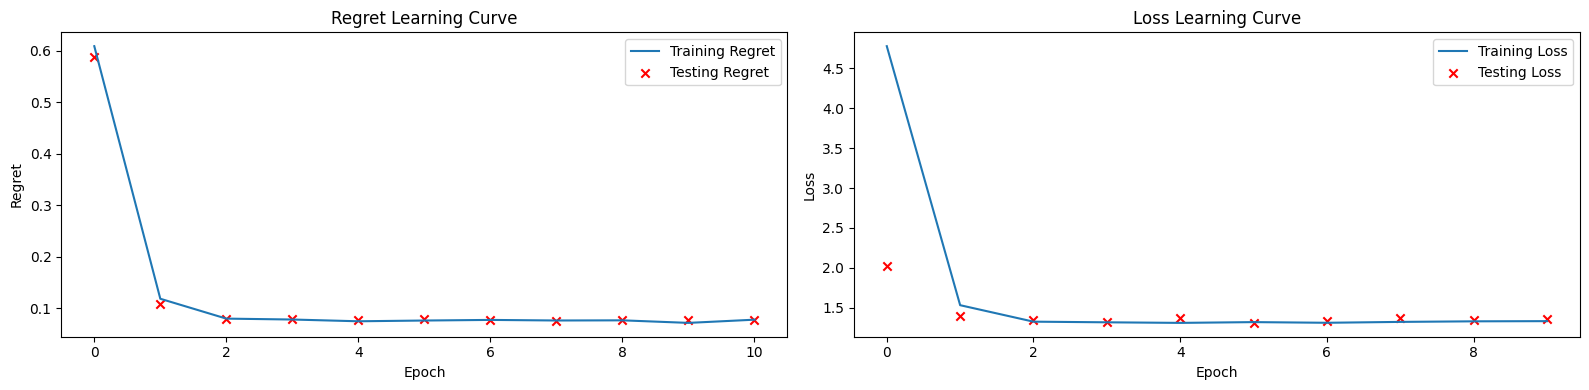

Final regret on test set:  0.07589601607671055


In [13]:
Trainer.vis_learning_curve(
    trainer,
    train_loss_log,
    train_regret_log,
    test_loss_log,
    test_regret_log
)

print("Final regret on test set: ", test_regret_log[-1])

### Differentiable Black Box Trainer
We will now train the Black Box trainer to compare the different performances. Note that the best comparison is the regret, as it is calculated independent of the chosen loss model.

In [14]:
# Instantiate new linear regression model
model = LinearRegression(num_feat=num_feat, num_edges=opt_model.num_cost)

In [15]:
# Init dbb solver
dbb = pyepo.func.blackboxOpt(opt_model, lambd=20)
# Set loss
from torch import nn
l1 = nn.L1Loss()

# Loss function
def dbbl1(cp, c, z):
    # Black-box optimizer
    wp = dbb(cp)
    # Objective value
    zp = (wp * c).sum(1).view(-1, 1)
    # Loss
    loss = l1(zp, z)
    return loss

# Init optimizer
from torch import optim
optimizer = optim.Adam(model.parameters(), lr=1e-2)

Num of cores: 1


In [16]:
# Create a trainer instance
trainer = Trainer(pred_model=model, 
                  opt_model=opt_model, 
                  optimizer=optimizer, 
                  loss_fn=dbbl1, 
                  method_name="dbb"
               )

# Train the model with DBB loss
train_loss_log, train_regret_log, test_loss_log, test_regret_log = trainer.fit(loader_train, loader_test, epochs=epochs)

Epoch 00 | Train Loss: 1.2730 | Train Regret: 0.2244 | Test Loss: 0.8198 | Test Regret: 0.2270
Epoch 01 | Train Loss: 0.6525 | Train Regret: 0.1587 | Test Loss: 0.5947 | Test Regret: 0.1647
Epoch 02 | Train Loss: 0.5249 | Train Regret: 0.1321 | Test Loss: 0.4652 | Test Regret: 0.1288
Epoch 03 | Train Loss: 0.4254 | Train Regret: 0.1161 | Test Loss: 0.4556 | Test Regret: 0.1262
Epoch 04 | Train Loss: 0.4095 | Train Regret: 0.1132 | Test Loss: 0.4490 | Test Regret: 0.1244
Epoch 05 | Train Loss: 0.4112 | Train Regret: 0.1017 | Test Loss: 0.4182 | Test Regret: 0.1158
Epoch 06 | Train Loss: 0.3879 | Train Regret: 0.0992 | Test Loss: 0.3935 | Test Regret: 0.1090
Epoch 07 | Train Loss: 0.3839 | Train Regret: 0.1039 | Test Loss: 0.3684 | Test Regret: 0.1020
Epoch 08 | Train Loss: 0.3931 | Train Regret: 0.1499 | Test Loss: 0.5647 | Test Regret: 0.1564
Epoch 09 | Train Loss: 0.4633 | Train Regret: 0.1133 | Test Loss: 0.4096 | Test Regret: 0.1134


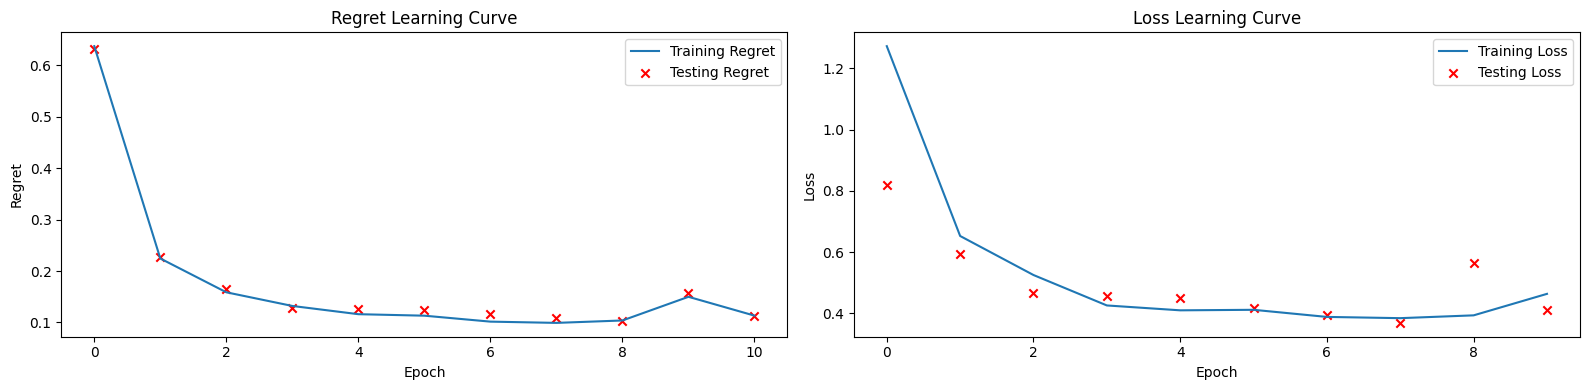

Final regret on test set:  0.113436004740194


In [17]:
trainer.vis_learning_curve(
    trainer,
    train_loss_log,
    train_regret_log,
    test_loss_log,
    test_regret_log
)

print("Final regret on test set: ", test_regret_log[-1])